This notebook contains a solution for the CartPole problem using Actor-Critic policy gradient method where the critic predicts the state value function, the updates are based on TD(0), and the advantage function is:

In [2]:
from IPython.display import display, Math
display(Math(r'A^{\pi_\theta}(s,a) = r + \gamma V_v(S_{t+1}) - V_v(S_t)'))

<IPython.core.display.Math object>

[2017-08-04 04:31:56,442] Making new env: CartPole-v0


Episode: 99, Mean reward: 18
Episode: 199, Mean reward: 20
Episode: 299, Mean reward: 27
Episode: 399, Mean reward: 34
Episode: 499, Mean reward: 44
Episode: 599, Mean reward: 50
Episode: 699, Mean reward: 54
Episode: 799, Mean reward: 64
Episode: 899, Mean reward: 83
Episode: 999, Mean reward: 129
Episode: 1099, Mean reward: 180
Episode: 1199, Mean reward: 171
Episode: 1299, Mean reward: 127
Episode: 1399, Mean reward: 182
Mean reward:  88.1259568546
Max 100 rewards mean:  199.55
Max 100 rewards from episode: 1337, to episode: 1436


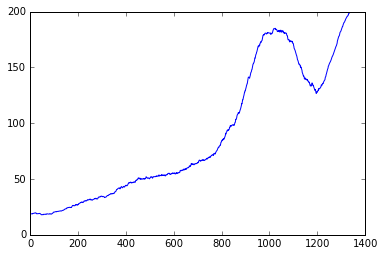

Play 20 times with optimal policy
Iteration: 0, Total Reward: 200
Iteration: 1, Total Reward: 200
Iteration: 2, Total Reward: 200
Iteration: 3, Total Reward: 200
Iteration: 4, Total Reward: 200
Iteration: 5, Total Reward: 200
Iteration: 6, Total Reward: 200
Iteration: 7, Total Reward: 200
Iteration: 8, Total Reward: 200
Iteration: 9, Total Reward: 200
Iteration: 10, Total Reward: 200
Iteration: 11, Total Reward: 200
Iteration: 12, Total Reward: 200
Iteration: 13, Total Reward: 200
Iteration: 14, Total Reward: 200
Iteration: 15, Total Reward: 200
Iteration: 16, Total Reward: 200
Iteration: 17, Total Reward: 200
Iteration: 18, Total Reward: 200
Iteration: 19, Total Reward: 200


In [1]:
import numpy as np
import tensorflow as tf
import gym
import random
import matplotlib.pyplot as plt
from collections import deque

%matplotlib inline

env = gym.make('CartPole-v0')
max_num_episodes = 10000
checkpoint = 100

actor_learning_rate = 0.01
critic_learning_rate = 0.001

decay = 0.99
 
class Actor:
    def __init__(self):
        with tf.variable_scope('Actor'):
            self._X = tf.placeholder(dtype=tf.float32, shape=(None, 4))
            self._rewards = tf.placeholder(dtype=tf.float32, shape=(None,1))
            self._logits = tf.contrib.layers.fully_connected(self._X, 2, activation_fn=None)
            self._policy = tf.contrib.layers.softmax(self._logits)
            self._actions = tf.placeholder(dtype=tf.float32, shape=(None,2))
            self._delta = tf.log(tf.reduce_sum(tf.mul(self._policy, self._actions), axis=1)) * self._rewards
            self._train_step = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(-1 * self._delta)

    def predict_policy(self, state):
        return self._policy.eval(feed_dict={self._X: state.reshape((-1, 4))})
    
    def train_policy(self, states, actions, rewards):
        actions_mask = np.zeros((len(actions), 2))
        actions_mask[range(len(actions)), actions] = 1
        return self._train_step.run(feed_dict={self._X: states.reshape((-1, 4)), self._actions: actions_mask, self._rewards: rewards.reshape((-1,1))})

class Critic:
    def __init__(self):
        with tf.variable_scope('Critic'):
            self._X = tf.placeholder(dtype=tf.float32, shape=(None, 4))
            self._y = tf.placeholder(dtype=tf.float32, shape=(None, 1))
            self._net = tf.contrib.layers.fully_connected(self._X, 15)
            self._Q = tf.contrib.layers.fully_connected(self._net, 1, activation_fn=None)
            self._mse = tf.contrib.losses.mean_squared_error(self._y, self._Q)
            self._train_step = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self._mse)

    def predict_Q(self, state):
        return self._Q.eval(feed_dict={self._X: state.reshape((-1, 4))})
    
    def train_Q(self, states, targets):
        return self._train_step.run(feed_dict={self._X: states.reshape((-1, 4)), self._y: targets.reshape((-1, 1))})
        
def stats(rewards):
    print("Mean reward: ", np.mean(rewards))
    rewards_100 = []
    for i in range(100, len(rewards) + 1):
        rewards_100.append(np.mean(rewards[i-100:i]))
    print("Max 100 rewards mean: ", np.max(rewards_100))
    re = np.argmax(rewards_100)
    print("Max 100 rewards from episode: %d, to episode: %d" % (re, re + 99))
    plt.plot(rewards_100)
    plt.show()

tf.reset_default_graph()
all_rewards = []

actor = Actor()
critic = Critic()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


for episode in range(max_num_episodes):
    state = env.reset()
    epsilon = 1./((episode/50) + 10)
    done = False
    episode_reward = 0
    experiences = []
    while not done:
        action = np.random.choice(range(2), p=actor.predict_policy(state)[0])

        # Perform action
        next_state, reward, done, _ = env.step(action)

        # Append final reward for each episode
        episode_reward += reward

        # Change 0 reward to -1 to learn more from punishment
        if reward == 0:
            reward = -1

        # Save experience
        experiences.append([state, action, reward, next_state, done])

        # Switch to next state
        state = next_state
        
    states = np.vstack([x[0] for x in experiences])
    actions = np.array([x[1] for x in experiences])
    rewards = np.array([x[2] for x in experiences])
    next_states = np.vstack([x[3] for x in experiences])
    episode_done = np.array([x[4] for x in experiences])

    curr_v = critic.predict_Q(states)
    next_v = critic.predict_Q(next_states)
    bootstrapped_value = rewards + decay * next_v[:, 0] * ~episode_done
    actor.train_policy(states, actions, bootstrapped_value - curr_v[:, 0])
    critic.train_Q(states, bootstrapped_value)
            

    if (episode + 1) % checkpoint == 0:
        print("Episode: %d, Mean reward: %d" % (episode, np.mean(all_rewards[-100:])))
    
    all_rewards.append(episode_reward)
    
    if np.mean(all_rewards[-100:]) > 199.5:
        break

stats(all_rewards)

print("Play 20 times with optimal policy")
for i in range(20):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state, reward, done, _ = env.step(np.random.choice(range(2), p=actor.predict_policy(state)[0]))
        total_reward += reward
        env.render()
    print("Iteration: %d, Total Reward: %d" % (i, total_reward))
    
sess.close()
env.close()